In [64]:
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import math
import datetime
import random
import copy
from tqdm import tqdm

#import category_encoders as ce
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
#from sklearn.svm import SVC
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline 


from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#import train and test datasets
train1 = pd.read_csv('/home/felix/Downloads/zimnat/Train.csv', parse_dates = ['join_date'])
test1 = pd.read_csv('/home/felix/Downloads/zimnat/Test.csv', parse_dates=['join_date'])
submission = pd.read_csv('/home/felix/Downloads/zimnat/SampleSubmission.csv')

In [3]:
# Split features and labels
train1_labels = train1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)
train1_features = train1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_features = test1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_labels = test1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train1_features, test1_features]).reset_index(drop=True)
print(all_features.shape, train1_labels.shape, test1_labels.shape)

(39132, 8) (29132, 21) (10000, 21)


In [4]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:9]

Percent of missing data


[('join_date', 0.01),
 ('ID', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [5]:
def handl_miss(df):
    df['join_date'] = df.groupby('branch_code')['join_date'].transform(lambda x: x.fillna(x.mode()[0]))
    return df


all_features = handl_miss(all_features)    

In [6]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('ID', 0.0),
 ('join_date', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [13]:
all_features['age'] = 2020 - all_features['birth_year']
all_features['join_year'] = all_features['join_date'].dt.year
all_features['join_month'] = all_features['join_date'].dt.month
all_features['join_day'] = all_features['join_date'].dt.day

dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
all_features['time_period'] = dt - all_features['join_date']

all_features['ageWJ'] = all_features['join_date'].dt.year - all_features['birth_year']
all_features['year_num'] = 2020 - all_features['join_year']

all_features['time_period'] = all_features['time_period'].astype(str)
all_features['time_period'] = all_features['time_period'].str.extract('(\d+)').astype(int)
all_features['yr_0'] = all_features['time_period'] / 365

In [14]:
def logs(res, ls):
    m =res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['birth_year', 'age', 'ageWJ']

all_features = logs(all_features, log_features)

In [15]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [16]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

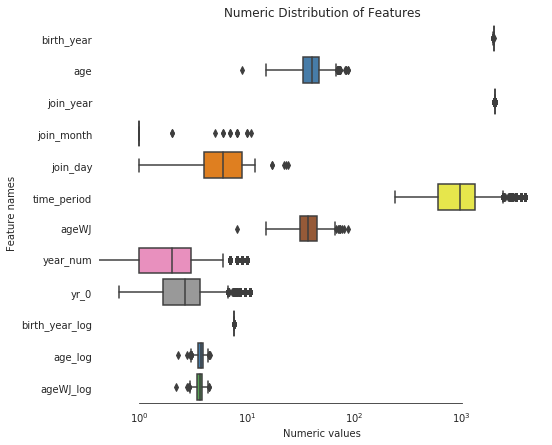

In [17]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [18]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: x.skew()).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(20)

There are 4 numerical features with Skew > 0.5 :


join_month        65.106593
yr_0               1.500776
time_period        1.500776
year_num           1.496821
ageWJ              0.247440
age                0.246128
join_day           0.166672
ageWJ_log         -0.244608
birth_year        -0.246128
age_log           -0.253791
birth_year_log    -0.256419
join_year         -1.496821
dtype: float64

In [19]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [20]:
all_features.shape

(39132, 19)

In [21]:
all_features.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.480195,32,0.716661,0.918592,7.594889,3.526655,3.496811
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.455124,38,0.716661,0.914992,7.591867,3.689129,3.663818
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.316233,22,2.300857,1.869704,7.596899,3.401531,3.135929
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,0.152703,8,13.442539,29,0.716661,0.913186,7.596397,3.434310,3.401531
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,0.152703,8,13.442539,29,0.716661,0.913186,7.596397,3.434310,3.401531


In [22]:
X_train__ = all_features.iloc[:len(train1_labels), :]
X_test__ = all_features.iloc[len(train1_labels):, :]
X_train__.shape, train1_labels.shape, X_test__.shape, test1_labels.shape

((29132, 19), (29132, 21), (10000, 19), (10000, 21))

In [23]:
train = pd.concat([X_train__, train1_labels], axis=1)

In [24]:
X_test__ = X_test__.reset_index(drop=True)
test = pd.concat([X_test__, test1_labels], axis=1)

In [25]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.480195,32,0.716661,0.918592,7.594889,3.526655,3.496811,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.455124,38,0.716661,0.914992,7.591867,3.689129,3.663818,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.316233,22,2.300857,1.869704,7.596899,3.401531,3.135929,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,0.152703,8,13.442539,29,0.716661,0.913186,7.596397,3.434310,3.401531,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,0.152703,8,13.442539,29,0.716661,0.913186,7.596397,3.434310,3.401531,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [26]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.315720,34,1.158462,1.184703,7.593379,3.611188,3.555634,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.429922,23,0.716661,0.911375,7.599406,3.219276,3.178470,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.325559,52,0.000000,0.495971,7.585286,3.970481,3.970481,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,31,2019,0.152703,2,13.480195,30,0.716661,0.918592,7.595895,3.466048,3.434310,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,38,2020,0.152703,2,10.312713,38,0.000000,0.494441,7.592371,3.663818,3.663818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
#print all dataset shape
print(train.shape, test.shape,submission.shape)

(29132, 40) (10000, 40) (210000, 2)


In [28]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], dtype='object')

In [29]:
X_train = []
X_train_columns = train.columns
c = 0
for v in train.values:
  info = v[:18]
  binary = v[18:]
  index = [k for k, i in enumerate(binary) if i == 1]
  for i in index:
    c+=1
    for k in range(len(binary)):
      if k == i:
        binary_transformed = list(copy.copy(binary))
        binary_transformed[i] = 0
        X_train.append(list(info) + binary_transformed + [X_train_columns[18+k]] + [c])

X_train = pd.DataFrame(X_train)
X_train.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'product_pred', 'ID2']

In [30]:
X_test = []
true_values = []
c = 0
for v in test.values:
  c += 1
  info = v[:18]
  binary = v[18:]
  index = [k for k, i in enumerate(binary) if i == 1]
  X_test.append(list(info) + list(binary) + [c])
  for k in test.columns[18:][index]:
    true_values.append(v[0] + ' X ' + k)

X_test = pd.DataFrame(X_test)
X_test.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'ID2']

In [31]:
features_train = []
features_test = []
columns = []

append_features = ['ID', 'ID2', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']
for v in append_features:
  features_train.append(X_train[v].values.reshape(-1, 1))
  features_test.append(X_test[v].values.reshape(-1, 1))
  columns.append(np.array([v]))

y_train = X_train[['product_pred']]

In [32]:
features_train = np.concatenate(features_train, axis=1)
features_test = np.concatenate(features_test, axis=1)
columns = np.concatenate(np.array(columns))

X_train = pd.DataFrame(features_train)
X_train.columns = columns
X_test = pd.DataFrame(features_test)
X_test.columns = columns

In [33]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)

In [34]:
X_train.drop('join_date', axis=1, inplace=True)
X_test.drop('join_date', axis=1, inplace=True)

In [35]:
X_train.head()

,ID,ID2,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.480195,32,0.716661,0.918592,7.594889,3.526655,3.496811,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4WKQSBB,2,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.480195,32,0.716661,0.918592,7.594889,3.526655,3.496811,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CP5S02H,3,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.455124,38,0.716661,0.914992,7.591867,3.689129,3.663818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,CP5S02H,4,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.455124,38,0.716661,0.914992,7.591867,3.689129,3.663818,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2YKDILJ,5,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.316233,22,2.300857,1.869704,7.596899,3.401531,3.135929,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
y_train.head()

,product_pred
0,RVSZ
1,K6QO
2,RVSZ
3,K6QO
4,SOP4


In [37]:
X_test.head()

,ID,ID2,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,1,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.315720,34,1.158462,1.184703,7.593379,3.611188,3.555634,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.429922,23,0.716661,0.911375,7.599406,3.219276,3.178470,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,3,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.325559,52,0.000000,0.495971,7.585286,3.970481,3.970481,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,4,M,M,1989,94KC,2A7I,T4MS,31,2019,0.152703,2,13.480195,30,0.716661,0.918592,7.595895,3.466048,3.434310,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,5,F,M,1982,UAOD,0KID,T4MS,38,2020,0.152703,2,10.312713,38,0.000000,0.494441,7.592371,3.663818,3.663818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [38]:
X_test.dtypes

ID                           object
ID2                           int64
sex                          object
marital_status               object
birth_year                    int64
branch_code                  object
occupation_code              object
occupation_category_code     object
age                           int64
join_year                     int64
join_month                  float64
join_day                      int64
time_period                 float64
ageWJ                         int64
year_num                    float64
yr_0                        float64
birth_year_log              float64
age_log                     float64
ageWJ_log                   float64
P5DA                          int64
RIBP                          int64
8NN1                          int64
7POT                          int64
66FJ                          int64
GYSR                          int64
SOP4                          int64
RVSZ                          int64
PYUQ                        

In [39]:
X_train.shape, y_train.shape, X_test.shape

((66353, 40), (66353, 1), (10000, 40))

In [61]:
#clustering

Xtrain_km = X_train.iloc[:, 19:] 
Xtest_km = X_test.iloc[:, 19:]
X_km = pd.concat([Xtrain_km, Xtest_km]).reset_index(drop=True)

X_km.head()
print(X_km.shape)

(76353, 21)


In [127]:
le = LabelEncoder()
le.fit(y_train.iloc[:,0])
y_train = pd.DataFrame(le.transform(y_train.iloc[:,0]))
y_train.columns = ['target']

In [ ]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).drop(['ID2'], axis=1).columns
cat_features = X_train.select_dtypes(include=['object', 'bool']).drop(['ID'], axis=1).columns

In [ ]:
t = [('cat', OneHotEncoder(), cat_features), ('num', StandardScaler(), num_features)]
col_transform = ColumnTransformer(transformers=t)

In [ ]:
proba = pipeline.predict_proba(X_test.drop(columns=['ID','ID2'], axis=1))
y_test = pd.DataFrame(proba)
y_test.columns = le.inverse_transform(y_test.columns)

In [ ]:
answer_mass = []
for i in range(X_test.shape[0]):
  id = X_test['ID'].iloc[i]
  for c in y_test.columns:
    answer_mass.append([id + ' X ' + c, y_test[c].iloc[i]])

df_answer = pd.DataFrame(answer_mass)
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
  if df_answer['ID X PCODE'].iloc[i] in true_values:
    df_answer['Label'].iloc[i] = 1.0

In [ ]:
df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('/home/felix/Downloads/zimnat/zinmat_submission2.csv', index=False)

# cluster

In [104]:
#clustering

Xtrain_km = X_train.iloc[:, 19:] 
Xtest_km = X_test.iloc[:, 19:]
X_km = pd.concat([Xtrain_km, Xtest_km]).reset_index(drop=True)

X_km.head()
print(X_km.shape)

(76353, 21)


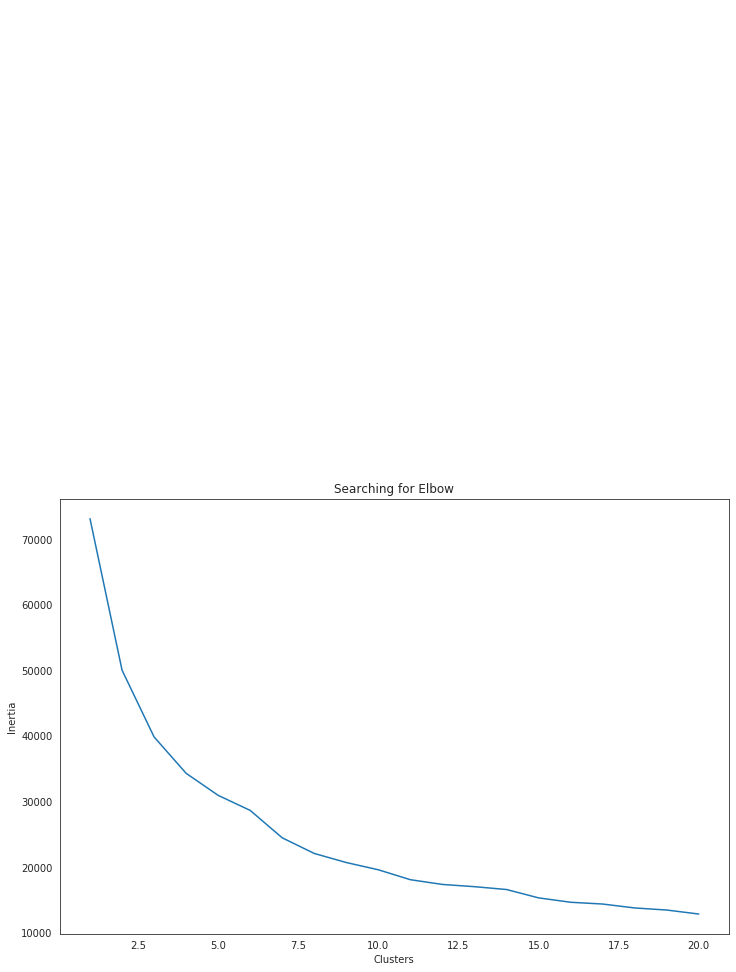

In [105]:
from sklearn.cluster import KMeans

clusters = []

for i in range(1, 21):
    km = KMeans(n_clusters=i).fit(X_km)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 21)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

In [113]:
# 5 cluster
km3 = KMeans(n_clusters=21).fit(X_km)

X_km['Labels'] = km3.labels_


In [115]:
X_km.head(15)

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,Labels
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,19
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,17


In [128]:
y_train.head(15)

,target
0,19
1,12
2,19
3,12
4,20
5,19
6,5
7,19
8,12
9,11


In [121]:
GO = pd.DataFrame(km3.labels_)
GT = pd.concat([GO, y_train])
GT.head()

,0,product_pred
0,1.0,NaN
1,5.0,NaN
2,1.0,NaN
3,5.0,NaN
4,19.0,NaN


In [136]:
GT = pd.merge(y_train, GO, left_index=True, right_index=True)
GT.head(30)

#pd.merge(df1, df2, left_index=True, right_index=True)

,target,0
0,19,1
1,12,5
2,19,1
3,12,5
4,20,19
5,19,0
6,5,5
7,19,1
8,12,5
9,11,17


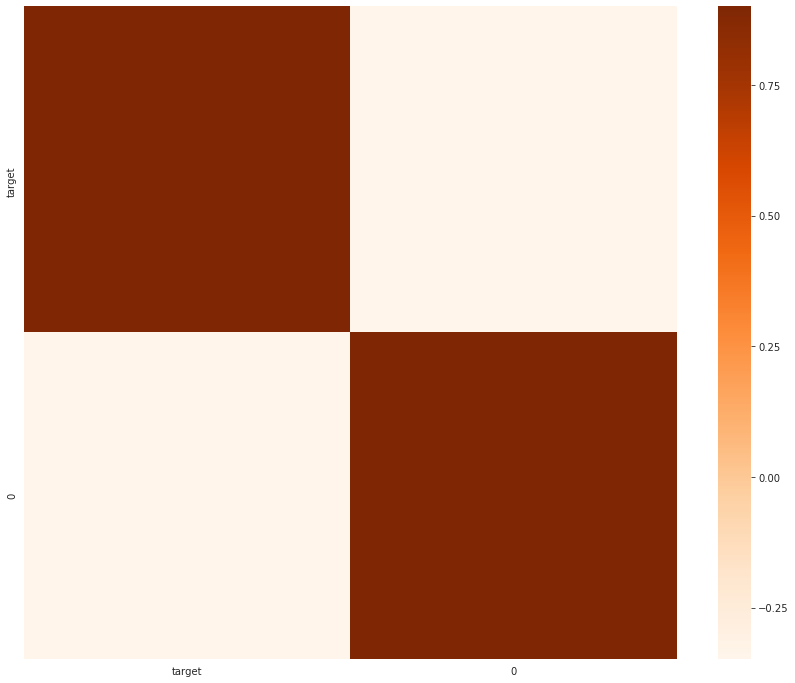

In [134]:
ggg = GT.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(ggg, vmax=0.9, cmap='Oranges', square=True)

In [135]:
print(GT.corr())

          target         0
target  1.000000 -0.347734
0      -0.347734  1.000000
